# Working with whole-body dataset

In [1]:
#For working wit Nifti file images on python-ipynb we need some new libraries
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set numpy to print only 2 decimal digits for neatness
np.set_printoptions(precision=2, suppress = True)

In [3]:
ct_wb = nib.load("data/ct_wb.nii.gz")
ct_wb_seg = nib.load("data/totalseg.nii.gz")
# This variables are instances of the nibabel image
# To work with the data:
ct_wb_data = ct_wb.get_fdata()
labels = ct_wb_seg.get_fdata()
ct_wb_data.shape


(400, 400, 326)

Text(0.5, 0.98, 'Center slices for CT-WB image')

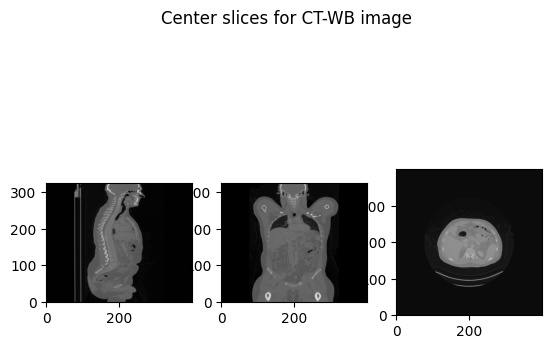

In [4]:
def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = ct_wb_data[200, :, :]
slice_1 = ct_wb_data[:, 200, :]
slice_2 = ct_wb_data[:, :, 163]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for CT-WB image") 

Text(0.5, 0.98, 'Center slices for CT-WB segmentated')

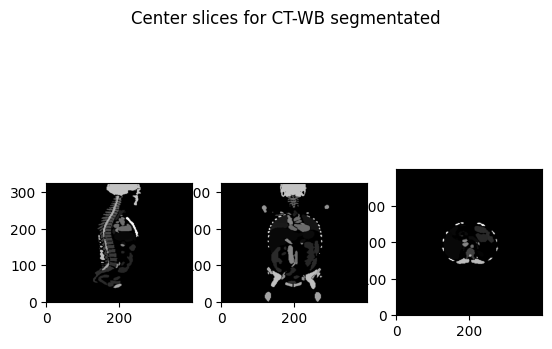

In [5]:
slice_0 = labels[200, :, :]
slice_1 = labels[:, 200, :]
slice_2 = labels[:, :, 163]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for CT-WB segmentated") 

In [6]:
# calculated_Bz = computed_Bz(matrix, image_res, sus_dist, buffer)
# So we need a sus distribution

unique_labels = np.unique(labels)
print("Unique labels:",unique_labels)

# So everylabel represents a different part of the body
# For example label 76 is the spinal cord

Unique labels: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114.]


In [7]:
total_labels = len(unique_labels)
for i in range(total_labels):
    print(unique_labels[i])

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0


In [8]:
# Calling the Segmenattion Label class to give attributes to the volume
# Because we want to give it a susceptibility distribution as well as name for each ID

from Volume import Volume

full_body_phantom = Volume(labels)




full_body_phantom.segmentation_labels




{0.0: SegmentationLabel(label_id=0.0, name=None, susceptibility=None),
 1.0: SegmentationLabel(label_id=1.0, name=None, susceptibility=None),
 2.0: SegmentationLabel(label_id=2.0, name=None, susceptibility=None),
 3.0: SegmentationLabel(label_id=3.0, name=None, susceptibility=None),
 4.0: SegmentationLabel(label_id=4.0, name=None, susceptibility=None),
 5.0: SegmentationLabel(label_id=5.0, name=None, susceptibility=None),
 6.0: SegmentationLabel(label_id=6.0, name=None, susceptibility=None),
 7.0: SegmentationLabel(label_id=7.0, name=None, susceptibility=None),
 8.0: SegmentationLabel(label_id=8.0, name=None, susceptibility=None),
 9.0: SegmentationLabel(label_id=9.0, name=None, susceptibility=None),
 10.0: SegmentationLabel(label_id=10.0, name=None, susceptibility=None),
 11.0: SegmentationLabel(label_id=11.0, name=None, susceptibility=None),
 12.0: SegmentationLabel(label_id=12.0, name=None, susceptibility=None),
 13.0: SegmentationLabel(label_id=13.0, name=None, susceptibility=None)

In [10]:
full_body_phantom.segmentation_labels.keys()

dict_keys([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0])